In [10]:
import networkx as nx

def hetero_to_networkx(data):
    G = nx.Graph()
    node_id_map = {}
    current_id = 0

    for ntype in data.node_types:
        num_nodes = data[ntype].num_nodes
        for i in range(num_nodes):
            global_id = current_id
            G.add_node(global_id, node_type=ntype, orig_id=i)
            node_id_map[(ntype, i)] = global_id
            current_id += 1

    for src_type, rel, dst_type in data.edge_types:
        edge_index = data[(src_type, rel, dst_type)].edge_index
        for src, dst in zip(edge_index[0].tolist(), edge_index[1].tolist()):
            src_global = node_id_map[(src_type, src)]
            dst_global = node_id_map[(dst_type, dst)]
            G.add_edge(src_global, dst_global, edge_type=rel)

    return G, node_id_map


In [12]:
import community.community_louvain as community_louvain

data = torch.load('../hetero_graph.pt', weights_only=False)  # Load your HeteroData object

G, node_id_map = hetero_to_networkx(data)

# Louvain community detection
partition = community_louvain.best_partition(G)

# Convert to: community_id → list of nodes
from collections import defaultdict
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

print(f"Detected {len(communities)} communities.")


Detected 201 communities.


In [18]:
import igraph as ig
import leidenalg

def networkx_to_igraph(G):
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G_ig = ig.Graph()
    G_ig.add_vertices(len(mapping))

    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    G_ig.add_edges(edges)

    return G_ig, mapping

G_ig, mapping = networkx_to_igraph(G)
partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)

# Map back community members
communities = []
for part in partition:
    community_nodes = [list(G.nodes())[i] for i in part]
    communities.append(community_nodes)

print(f"Detected {len(communities)} communities.")


Detected 202 communities.


In [7]:
def analyze_community(community_nodes, G):
    types = [G.nodes[n]['ntype'] for n in community_nodes]
    from collections import Counter
    print("Composition:", Counter(types))
    return types

# Example: analyze top 5 communities
for i, comm in enumerate(list(communities.values())[:5]):
    print(f"\nCommunity {i}: size {len(comm)}")
    analyze_community(comm, G)



Community 0: size 71
Composition: Counter({'reviewer': 35, 'review': 35, 'product': 1})

Community 1: size 5
Composition: Counter({'product': 1, 'reviewer': 1, 'brand': 1, 'category': 1, 'review': 1})

Community 2: size 174
Composition: Counter({'review': 86, 'reviewer': 84, 'product': 2, 'brand': 1, 'category': 1})

Community 3: size 505
Composition: Counter({'review': 253, 'reviewer': 251, 'product': 1})

Community 4: size 166
Composition: Counter({'review': 78, 'reviewer': 75, 'product': 8, 'brand': 4, 'category': 1})


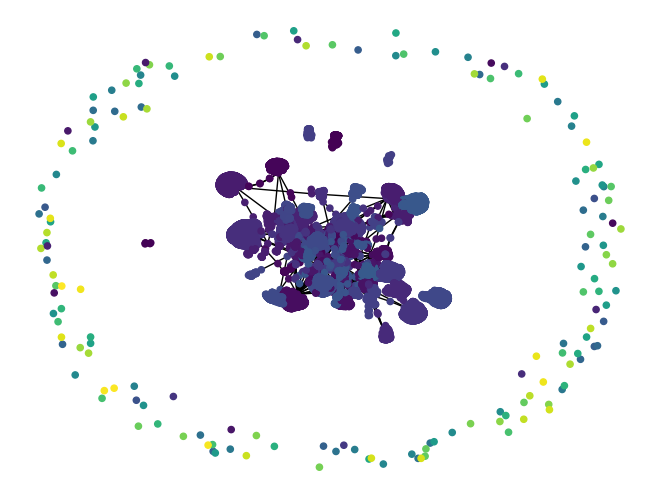

In [8]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=42)
colors = [partition[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, node_size=20, with_labels=False)
plt.show()



Scoring Function
You can define a suspiciousness score S(c) for community c as a weighted sum of the following metrics:

S(c) = α * Density(c) + β * Reviewer-to-Product Ratio + γ * Edge Concentration + δ * Time Burst Score
Where:

Metric	Description	Suspicious if...
- Density	#actual edges / #possible edges within community ->	High
- Reviewer-to-Product Ratio	Many reviewers → few products ->	High
- Edge Concentration	Many reviewers reviewing same products ->	High
- Time Burst	Most reviews in few days ->	High

In [19]:
from collections import defaultdict
import networkx as nx

# G: networkx graph with 'node_type' attribute
# partition: dict[node_id] -> community_id
community_nodes = defaultdict(list)
for node_id, comm_id in partition.items():
    community_nodes[comm_id].append(node_id)

def compute_suspiciousness(G, community_nodes):
    scores = {}
    for comm_id, nodes in community_nodes.items():
        subG = G.subgraph(nodes)
        num_nodes = subG.number_of_nodes()
        num_edges = subG.number_of_edges()

        # Density
        max_edges = num_nodes * (num_nodes - 1) / 2
        density = num_edges / max_edges if max_edges > 0 else 0

        # Reviewer-to-product ratio
        reviewers = [n for n in nodes if G.nodes[n]['node_type'] == 'reviewer']
        products = [n for n in nodes if G.nodes[n]['node_type'] == 'product']
        rev_to_prod_ratio = len(reviewers) / (len(products) + 1e-5)

        # Edge concentration: how many reviewers review the same product
        product_review_count = defaultdict(int)
        for u, v in subG.edges():
            if G.nodes[u]['node_type'] == 'reviewer' and G.nodes[v]['node_type'] == 'product':
                product_review_count[v] += 1
            elif G.nodes[v]['node_type'] == 'reviewer' and G.nodes[u]['node_type'] == 'product':
                product_review_count[u] += 1
        if product_review_count:
            avg_review_per_product = sum(product_review_count.values()) / len(product_review_count)
        else:
            avg_review_per_product = 0

        # Final suspiciousness score
        score = 0.5 * density + 0.3 * rev_to_prod_ratio + 0.2 * avg_review_per_product
        scores[comm_id] = score

    return scores

# Usage
suspiciousness_scores = compute_suspiciousness(G, community_nodes)
sorted_sus = sorted(suspiciousness_scores.items(), key=lambda x: x[1], reverse=True)
for comm_id, score in sorted_sus[:10]:
    print(f"Community {comm_id}: Suspiciousness Score = {score:.4f}")


AttributeError: 'ModularityVertexPartition' object has no attribute 'items'

In [15]:
for comm_id, score in sorted_sus:
    print(f"Community {comm_id}: Suspiciousness Score = {score:.4f}")

Community 20: Suspiciousness Score = 369.2967
Community 7: Suspiciousness Score = 220.1985
Community 12: Suspiciousness Score = 191.6989
Community 35: Suspiciousness Score = 187.7989
Community 23: Suspiciousness Score = 148.3498
Community 22: Suspiciousness Score = 139.4997
Community 21: Suspiciousness Score = 119.1001
Community 17: Suspiciousness Score = 114.9001
Community 25: Suspiciousness Score = 109.2003
Community 33: Suspiciousness Score = 108.6003
Community 32: Suspiciousness Score = 93.6007
Community 15: Suspiciousness Score = 81.0010
Community 3: Suspiciousness Score = 75.3012
Community 6: Suspiciousness Score = 70.5014
Community 10: Suspiciousness Score = 70.2014
Community 41: Suspiciousness Score = 63.0017
Community 13: Suspiciousness Score = 36.7509
Community 34: Suspiciousness Score = 35.4039
Community 24: Suspiciousness Score = 33.6041
Community 18: Suspiciousness Score = 33.0042
Community 37: Suspiciousness Score = 32.7042
Community 9: Suspiciousness Score = 27.4526
Comm

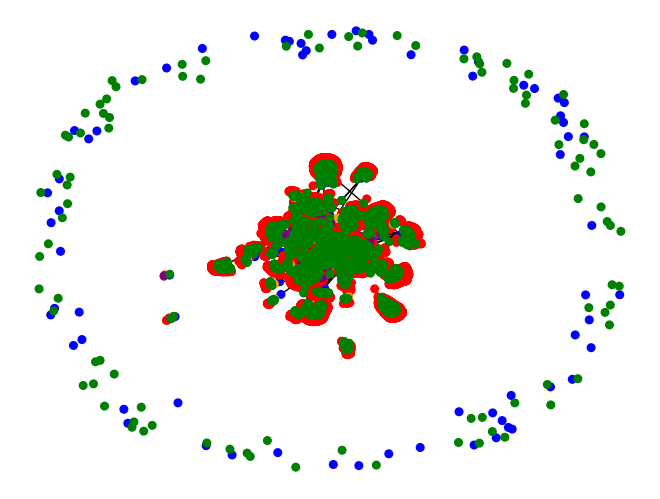

In [14]:
import matplotlib.pyplot as plt

colors = {'reviewer': 'red', 'product': 'blue', 'review': 'green',
          'brand': 'orange', 'category': 'purple'}
node_colors = [colors[G.nodes[n]['node_type']] for n in G.nodes()]
nx.draw(G, node_color=node_colors, with_labels=False, node_size=30)
plt.show()
